In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score

np.random.seed(7)

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

- documentar
- resolver outliers
- resolver o replace de null values de bmi
- analisar correlações
- avaliar desempenho dos modelos (com gráficos e obs)

In [2]:
data = pd.read_csv('archive.zip')
data.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [3]:
data['stroke'].value_counts().to_frame()

,stroke
0,4861
1,249


In [4]:
i = data.query('stroke == 0 and work_type != "children"').dropna(how='any', axis=0).index
n = data.query('stroke == 1').shape[0]+2

i_sampled = np.random.choice(i, n)

data = pd.concat([data.loc[i_sampled], data.query('stroke == 1')], axis=0).sort_index()

In [5]:
quantitative = ['age', 'avg_glucose_level', 'bmi']
qualitative = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
               'work_type', 'Residence_type', 'smoking_status','stroke']

In [6]:
data[quantitative].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 5091
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                500 non-null    float64
 1   avg_glucose_level  500 non-null    float64
 2   bmi                460 non-null    float64
dtypes: float64(3)
memory usage: 15.6 KB


In [7]:
data[qualitative].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 5091
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          500 non-null    object
 1   hypertension    500 non-null    int64 
 2   heart_disease   500 non-null    int64 
 3   ever_married    500 non-null    object
 4   work_type       500 non-null    object
 5   Residence_type  500 non-null    object
 6   smoking_status  500 non-null    object
 7   stroke          500 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 35.2+ KB


In [8]:
for column in qualitative:
    display(data[column].value_counts(normalize=False).to_frame())

,gender
Female,292
Male,208


,hypertension
0,409
1,91


,heart_disease
0,443
1,57


,ever_married
Yes,402
No,98


,work_type
Private,312
Self-employed,112
Govt_job,72
Never_worked,2
children,2


,Residence_type
Urban,256
Rural,244


,smoking_status
never smoked,189
formerly smoked,122
Unknown,113
smokes,76


,stroke
0,251
1,249


In [9]:
data['gender'] = data['gender'].apply(lambda x:1 if x == 'Female' else 0)

data['ever_married'] = data['ever_married'].apply(lambda x:1 if x=='Yes' else 0)

data['Residence_type'] = data['Residence_type'].apply(lambda x:1 if x=='Urban' else 0)

data['work_type_private'] = data['work_type'].apply(lambda x:1 if x=='Private' else 0)
data['work_type_govt_job'] = data['work_type'].apply(lambda x:1 if x=='Govt_job' else 0)
data['work_type_self_emp'] = data['work_type'].apply(lambda x:1 if x=='Self-employed' else 0)

data['smoking_status_never'] = data['smoking_status'].apply(lambda x:1 if x=='never smoked' or x=='Unknown' else 0)
data['smoking_status_formerly'] = data['smoking_status'].apply(lambda x:1 if x=='formerly smoked' else 0)
data['smoking_status_smokes'] = data['smoking_status'].apply(lambda x:1 if x=='smokes' else 0)


data.rename({'gender':'gender_female', 'Residence_type':'Residence_type_urban'}, axis=1, inplace=True)
data.drop(['work_type', 'smoking_status', 'id'], axis=1, inplace=True)

qualitative = ['gender_female', 'hypertension', 'heart_disease', 'ever_married', 
               'work_type_private', 'work_type_govt_job', 'work_type_self_emp', 
               'Residence_type_urban', 'smoking_status_never',
               'smoking_status_formerly','smoking_status_smokes', 'stroke']

In [10]:
q1 = data['bmi'].quantile(0.25)
q3 = data['bmi'].quantile(0.75)

IQR = q3 - q1

limite_superior = q3 + 1.25*IQR
limite_inferior = q1 - 1.25*IQR

data['bmi'] = data['bmi'].apply(lambda x:limite_superior if x>limite_superior else x)
data['bmi'] = data['bmi'].apply(lambda x:limite_inferior if x<limite_inferior else x)

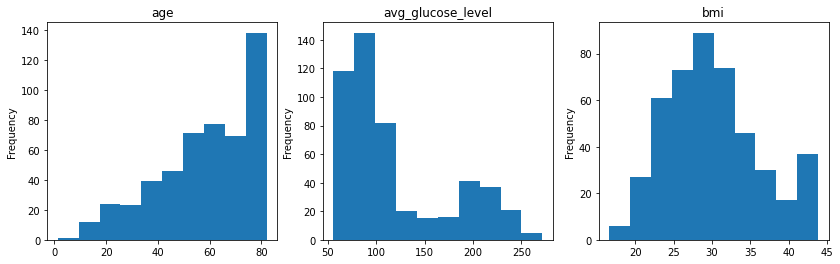

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

i = 0

for column in quantitative:
    ax[i].set_title(column)
    data[column].plot(kind='hist', ax=ax[i])
    i += 1

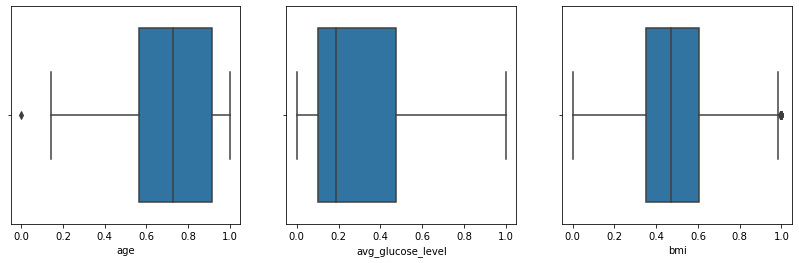

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

i = 0

for column in quantitative:
    sns.boxplot(data=data, x=column, ax=ax[i])
    i += 1

In [13]:
for column in quantitative:
    print(shapiro(data[column]))

ShapiroResult(statistic=0.9335173964500427, pvalue=4.014326983889718e-14)
ShapiroResult(statistic=0.838842511177063, pvalue=4.0632021466109493e-22)
ShapiroResult(statistic=nan, pvalue=1.0)


In [14]:
scaler = MinMaxScaler()

data[quantitative] = scaler.fit_transform(data[quantitative])

In [15]:
median = data['bmi'].median()
data['bmi'] = data['bmi'].replace(np.nan, median)

# mean = data['bmi'].mean()
# data['bmi'] = data['bmi'].replace(np.nan, mean)

# data.dropna(how='any', axis=0, inplace=True)

# data.dropna(how='any', axis=1, inplace=True)

In [16]:
data.corr()['stroke'].sort_values().to_frame()

,stroke
smoking_status_never,-0.109565
work_type_private,-0.052653
gender_female,-0.035838
work_type_govt_job,-0.032539
bmi,0.009068
smoking_status_smokes,0.046260
Residence_type_urban,0.060114
smoking_status_formerly,0.086093
work_type_self_emp,0.088497
ever_married,0.199554


In [17]:
X = data.drop('stroke', axis=1)
y = data['stroke']

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
model = LogisticRegression(random_state=7)

acs_train = []
acs_test = []

acertos_negativos = []
acertos_positivos = []

for train_index, test_index in kf.split(X):
    
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)

    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    acs_train.append(accuracy_train)
    
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    acs_test.append(accuracy_test)
    
    cm = confusion_matrix(y_test, model.predict(X_test))

    acertos_negativo = cm[0][0] / (cm[0][0] + cm[0][1])
    acertos_negativos.append(acertos_negativo)
    
    acertos_positivo = cm[1][1] / (cm[1][0] + cm[1][1])
    acertos_positivos.append(acertos_positivo)
    

acs_train = np.array(acs_train)
acs_test = np.array(acs_test)
acertos_negativos = np.array(acertos_negativos)
acertos_positivos = np.array(acertos_positivos)

print('Accuracy score for train set: %.4f +- %.4f' % (acs_train.mean(), acs_train.std()))
print('Accuracy score for test set: %.4f +- %.4f' % (acs_test.mean(), acs_test.std()))

print('\nPrecision for positive cases: %.2f%% +- %.2f%%' % (acertos_positivos.mean()*100, acertos_positivos.std()*100))
print('Precision for negative cases: %.2f%% +- %.2f%%' % (acertos_negativos.mean()*100, acertos_negativos.std()*100))

Accuracy score for train set: 0.7470 +- 0.0097
Accuracy score for test set: 0.7340 +- 0.0463

Precision for positive cases: 76.14% +- 8.35%
Precision for negative cases: 70.88% +- 7.70%


In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)
model = RandomForestClassifier(random_state=7)

acs_train = []
acs_test = []

acertos_negativos = []
acertos_positivos = []

for train_index, test_index in kf.split(X):
    
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)

    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    acs_train.append(accuracy_train)
    
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    acs_test.append(accuracy_test)
    
    cm = confusion_matrix(y_test, model.predict(X_test))

    acertos_negativo = cm[0][0] / (cm[0][0] + cm[0][1])
    acertos_negativos.append(acertos_negativo)
    
    acertos_positivo = cm[1][1] / (cm[1][0] + cm[1][1])
    acertos_positivos.append(acertos_positivo)
    

acs_train = np.array(acs_train)
acs_test = np.array(acs_test)
acertos_negativos = np.array(acertos_negativos)
acertos_positivos = np.array(acertos_positivos)

print('Accuracy score for train set: %.4f +- %.4f' % (acs_train.mean(), acs_train.std()))
print('Accuracy score for test set: %.4f +- %.4f' % (acs_test.mean(), acs_test.std()))

print('\nPrecision for positive cases: %.2f%% +- %.2f%%' % (acertos_positivos.mean()*100, acertos_positivos.std()*100))
print('Precision for negative cases: %.2f%% +- %.2f%%' % (acertos_negativos.mean()*100, acertos_negativos.std()*100))

Accuracy score for train set: 1.0000 +- 0.0000
Accuracy score for test set: 0.7180 +- 0.0264

Precision for positive cases: 75.87% +- 4.77%
Precision for negative cases: 67.81% +- 6.66%
